In [1]:
############################
# IMPORTACION DE LIBRERIAS #
############################

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

#warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


In [2]:
##################
# CARGA DE DATOS #
##################

traindata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt')#reading the data
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt')
print('Number of rows and columns of the training set: ',traindata.shape)
print('Number of rows and columns of the test set: ',testdata.shape)

/home/rafa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of rows and columns of the training set:  (363834, 89)
Number of rows and columns of the test set:  (156315, 88)


In [3]:
#####################################
# SEPARACION DE VARIABLES POR TIPOS #
#####################################

numeric_cols=traindata.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=traindata.select_dtypes(exclude=[np.number]).columns#select only non numerical
print(numeric_cols.shape[0],'numeric columns: ',numeric_cols)
print(nominal_cols.shape[0],'nominal columns: ',nominal_cols)

87 numeric columns:  Index(['Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03', 'Imp_Cons_04',
       'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07', 'Imp_Cons_08',
       'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11', 'Imp_Cons_12',
       'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15', 'Imp_Cons_16',
       'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03', 'Imp_Sal_04',
       'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08', 'Imp_Sal_09',
       'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13', 'Imp_Sal_14',
       'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18', 'Imp_Sal_19',
       'Imp_Sal_20', 'Imp_Sal_21', 'Ind_Prod_01', 'Ind_Prod_02', 'Ind_Prod_03',
       'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06', 'Ind_Prod_07',
       'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10', 'Ind_Prod_11',
       'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14', 'Ind_Prod_15',
       'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18', 'Ind_Prod_19',
       'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22', 'I

In [8]:
###############################
# FUNCIONES PARA PREPROCESADO #
###############################

def iqr_calculate(column):
    description = column.describe()
    iqr = description['75%']-description['25%']
    return iqr

def outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-1.5*iqr,description['75%']+1.5*iqr]
    return outliers_limits

def extreme_outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-3*iqr,description['75%']+3*iqr]
    return outliers_limits

def mostrar_histograma(column, bins, label = None):
    fig, ax = plt.subplots()
    ax.hist(column, bins)
    ax.set_xlabel(label)
    plt.show()
    
def delete_extreme_outliers(data, column):
    limits = extreme_outliers_limits(column)
    data_without_extreme_outliers = data[column<=limits[1]]
    data_without_extreme_outliers = data_without_extreme_outliers[column>=limits[0]]
    return data_without_extreme_outliers
    




Rango intercuartilico de variable objetivo: 9647.60439575
Limites (inferior y superior) de los valores atipicos: [-5170.4740936249964, 33419.943489375]
Limites (inferior y superior) de los valores extremadamente atipicos: [-19641.880687249992, 47891.350082999998]


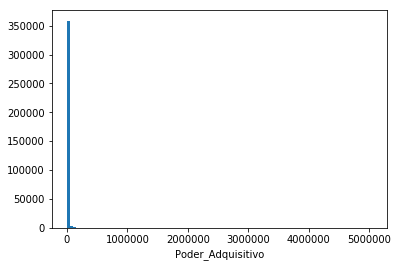

/home/rafa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


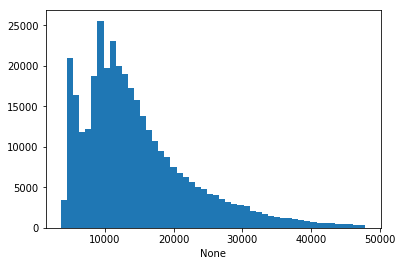

In [10]:
print ('Rango intercuartilico de variable objetivo:', iqr_calculate(traindata['Poder_Adquisitivo']))
print ('Limites (inferior y superior) de los valores atipicos:', outliers_limits(traindata['Poder_Adquisitivo']))
print ('Limites (inferior y superior) de los valores extremadamente atipicos:', extreme_outliers_limits(traindata['Poder_Adquisitivo']))

mostrar_histograma(traindata['Poder_Adquisitivo'], 100, 'Poder_Adquisitivo')
traindata_without_extreme_outliers = delete_extreme_outliers(traindata, traindata['Poder_Adquisitivo'])
mostrar_histograma(traindata_without_extreme_outliers['Poder_Adquisitivo'], 50)